In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset|
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from MountainDataset import MountainDataset
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
DEVICE

True


'cuda'

In [2]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image_path = "./dataset_3Peaks/"
train_data = MountainDataset(image_path)


In [4]:
print(train_data)

Mountain Data Set
Root directory: {self.rootDir}Length 12975


In [5]:
#TODO Data Normalization should be done Previously. Saves Startup time
def create_validation_set(train_data, train_percentage, test_transforms = None):

    
    n_train_examples = int(len(train_data) * train_percentage)
    n_valid_examples = len(train_data) - n_train_examples
    
     # Create 'Subset' objects
    train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

    print(f"Number training examples: {len(train_data)}")
    print(f"Number validation examples: {len(valid_data)}")

    # Apply test transformations to the validation set
    valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
    valid_data.dataset.transform = test_transforms

    return valid_data

In [6]:
valid_data = create_validation_set(train_data, 0.8)

Number training examples: 10380
Number validation examples: 2595


In [7]:
# Create iterators
#TODO: Maybe change batch Size to 32 if memory runs out
BATCH_SIZE = 5

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

#test_iterator = torch.utils.data.DataLoader(test_data, 
#                                            batch_size=BATCH_SIZE)

In [10]:
from unet_online import UNet
loadPath = "./unet_3Peaks.pt"
#model = torch.load(loadPath)
model = UNet(1,1)

In [11]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 1,864,257 trainable parameters.


In [ ]:
#Todo look more into the Criterion for now Softmax + Crossentropy sounds good
# Loss
# Crossentropy works only with multiple classes -> use BCEwith logitsloss instead
#criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
criterion = nn.BCEWithLogitsLoss()
# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
# Optim
startLR = 0.001
# Optim
optimizer = optim.SGD(model.parameters(), lr = startLR)#, momentum=0.99)

#optimizer = optim.RMSprop(model.parameters(), lr=startLR, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)
#Continously improve LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

model = model.to(device)

In [9]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  counter = 0
  # Train mode
  model.train()
  
  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    counter+=BATCH_SIZE
    
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Make Predictions
    y_pred = model(x)
    # Compute loss
    loss = criterion(y_pred, y)
    
    probs  = torch.sigmoid(y_pred)
    probs/=torch.amax(probs)
    # Compute accuracy
    acc = iou_pytorch(probs, y)
    
    # Backprop
    loss.backward()
    

    
    
    

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  #print(f"epoch_acc:{epoch_acc/len(iterator)} , len: {len(iterator)}")
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [13]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)
      
      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)
      
      # Compute accuracy
      probs  = torch.sigmoid(y_pred)

      # Compute accuracy
      acc, seg = iou_pytorch(probs, y, segment=True)
      
      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
    for i in range(2):
        print(torch.amax(x[i,0]).item(), torch.amax(probs[i,0]).item(), torch.amax(y[i,0]).item())
        print(torch.amin(x[i,0]).item(), torch.amin(probs[i,0]).item(), torch.amin(y[i,0]).item())
        plot_img([x[i,0], y_pred[i,0], seg[i], y[i,0]])
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def plot_img(imgs):
  fig = plt.figure(figsize=(20,10))
  gs = fig.add_gridspec(1,len(imgs), hspace=0)
  axs = gs.subplots()
  for i, img in enumerate(imgs):
        axs[i].imshow(img.cpu().detach().numpy())

  #cbar_ax = fig.add_axes([0,0, im1.size()[0], im1.size()[1]])
  #fig.subplots_adjust(right=0.8)
  #fig.colorbar(im2.detach().numpy(), cax=cbar_ax)
  plt.show()

In [14]:
#def acc(pred, mask):
#    compare= np.equal(pred.detach().cpu().numpy(), mask.detach().cpu().numpy())
#    accuracy = np.sum(compare)
#    return accuracy/len(pred.flatten())
#
#
#
#def calculate_accuracy(y_pred, y, batch_size):
#    '''
#    Compute accuracy from ground-truth and predicted labels.
#    
#    Input
#    ------
#    y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
#    y: torch.Tensor [BATCH_SIZE]
#  
#    Output
#    ------
#    acc: float
#      Accuracy
#    '''
#    batch_size= min(y.shape[0], batch_size)
#    total_acc = 0
#    for i in range(batch_size):
#        total_acc += acc(y_pred[i], y[i])
#    
#    
#    return total_acc/batch_size
#
def calculate_accuracy(pred, label):
    probs = torch.sigmoid(pred, dim = 1)
    _, tags = torch.max(probs, dim = 1)
    corrects = torch.eq(tags,label).int()
    acc = corrects.sum()/corrects.numel()
    return acc

EPS = 1e-6
#slightly modified
def iou_pytorch(out, lab, segment = False):
    outputs = torch.squeeze(out, 1)
    for i in range(len(outputs)):
        outputs[i]/= torch.amax(outputs[i])
    outputs = (outputs+0.25).int()
    #outputs[outputs< -1] = -1
    labels = (lab).int()
    # Taken from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + EPS) / (union + EPS)  # We smooth our devision to avoid 0/0
    if iou.mean()<0:
        print(iou.mean())
    if segment:
        return iou.mean(), outputs
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch
    return iou.mean()

In [15]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
      model.save_model(model_name)
    end_time = time.time()
    
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

1.0 1.0 1.0
0.0 0.000981251010671258 0.0


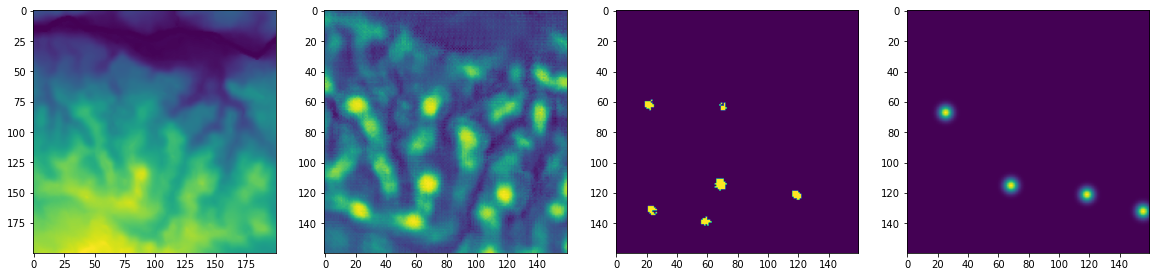

1.0 1.0 1.0
0.0 0.0003720202948898077 0.0


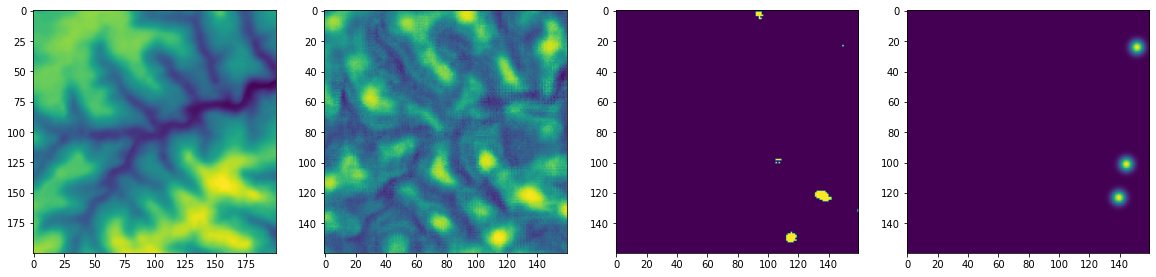


Epoch: 1/20 -- Epoch Time: 3024.20 s
---------------------------------
Train -- Loss: 0.047, Acc: 49.62%
Val -- Loss: 0.047, Acc: 48.84%
1.0 1.0 1.0
0.0 0.0010113659081980586 0.0


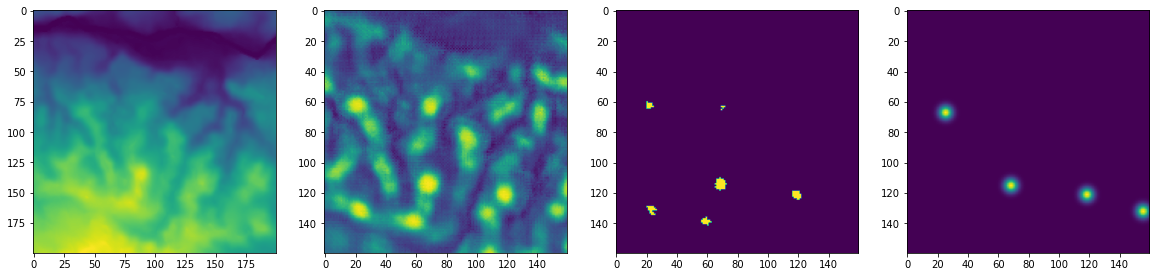

1.0 1.0 1.0
0.0 0.00039839910459704697 0.0


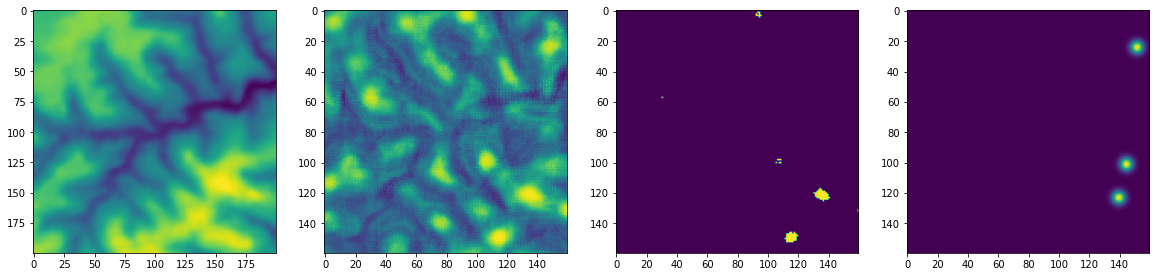


Epoch: 2/20 -- Epoch Time: 3163.90 s
---------------------------------
Train -- Loss: 0.047, Acc: 49.82%
Val -- Loss: 0.046, Acc: 47.89%
1.0 1.0 1.0
0.0 0.0007565959240309894 0.0


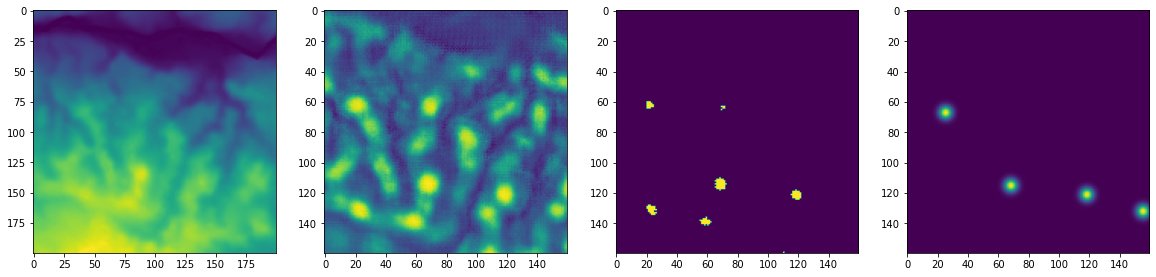

1.0 1.0 1.0
0.0 0.00029311314574442804 0.0


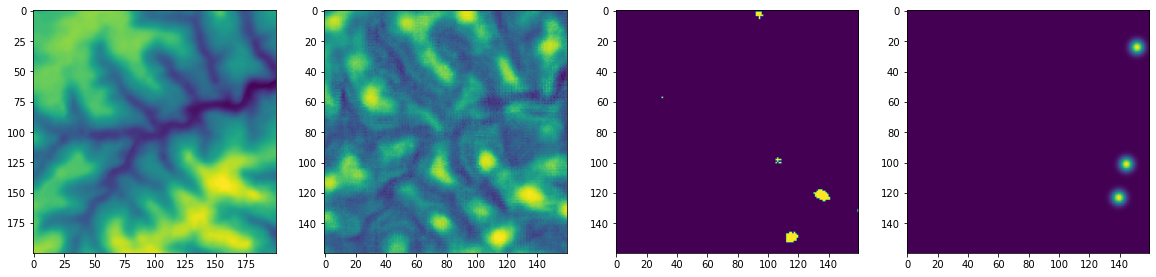


Epoch: 3/20 -- Epoch Time: 2906.87 s
---------------------------------
Train -- Loss: 0.047, Acc: 49.78%
Val -- Loss: 0.046, Acc: 44.09%
1.0 1.0 1.0
0.0 0.0008069907198660076 0.0


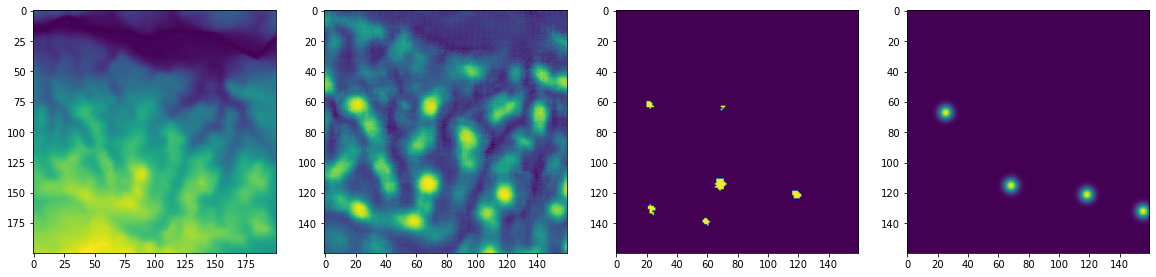

1.0 1.0 1.0
0.0 0.0003396057873032987 0.0


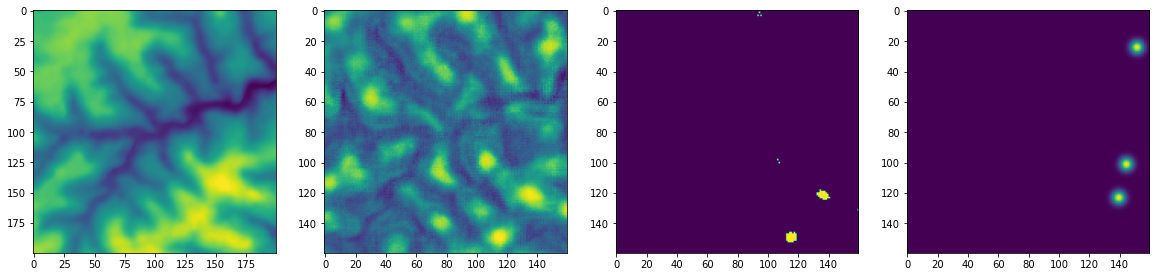


Epoch: 4/20 -- Epoch Time: 2819.35 s
---------------------------------
Train -- Loss: 0.047, Acc: 50.35%
Val -- Loss: 0.046, Acc: 53.09%
1.0 1.0 1.0
0.0 0.000800195848569274 0.0


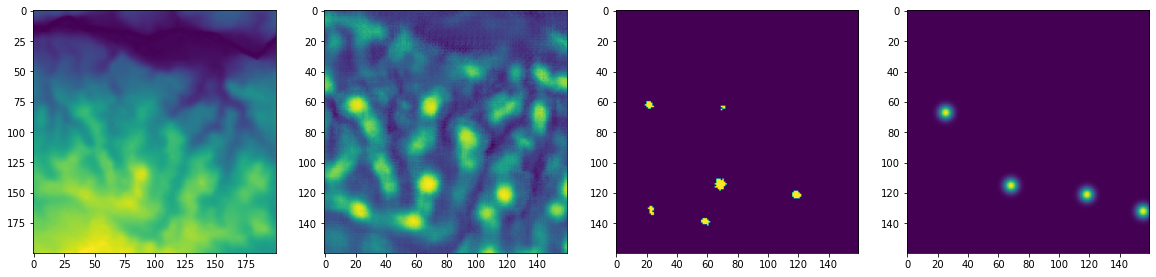

1.0 1.0 1.0
0.0 0.0003575801383703947 0.0


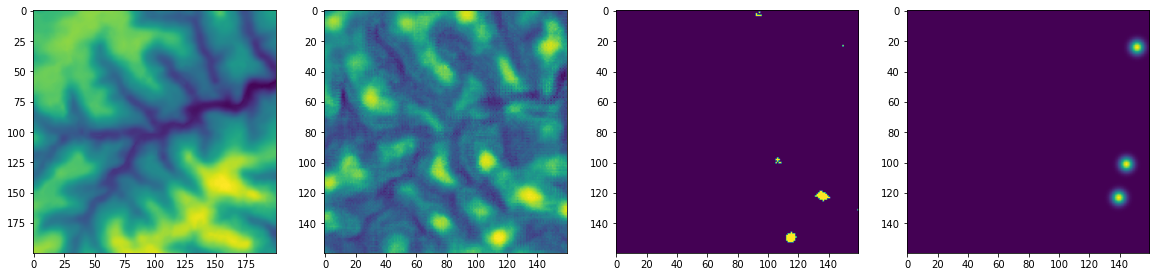


Epoch: 5/20 -- Epoch Time: 2816.23 s
---------------------------------
Train -- Loss: 0.046, Acc: 50.68%
Val -- Loss: 0.046, Acc: 53.25%
1.0 1.0 1.0
0.0 0.0006049018702469766 0.0


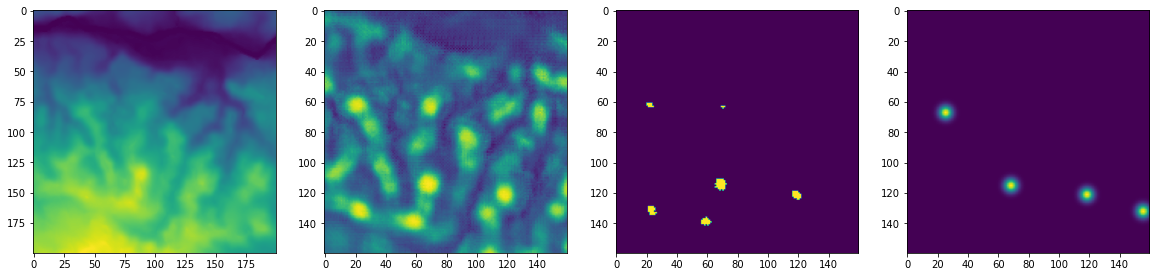

1.0 1.0 1.0
0.0 0.0002853343612514436 0.0


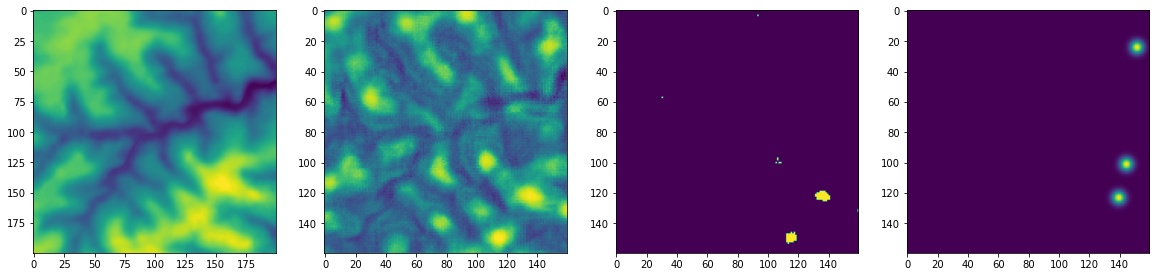


Epoch: 6/20 -- Epoch Time: 2802.26 s
---------------------------------
Train -- Loss: 0.046, Acc: 51.21%
Val -- Loss: 0.046, Acc: 47.94%
1.0 1.0 1.0
0.0 0.0005820730002596974 0.0


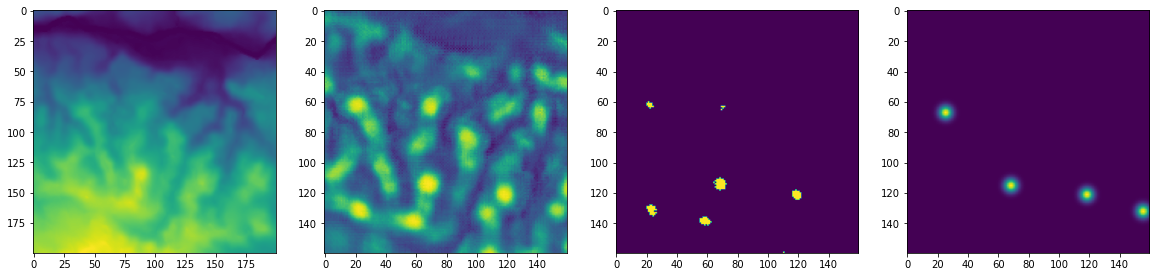

1.0 1.0 1.0
0.0 0.0002571757650002837 0.0


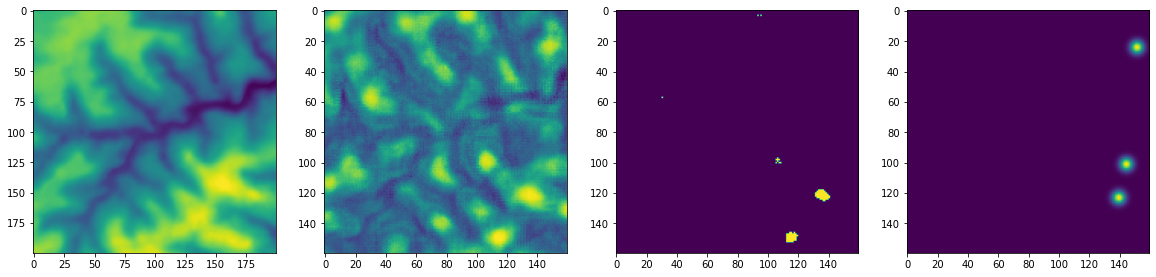


Epoch: 7/20 -- Epoch Time: 2787.08 s
---------------------------------
Train -- Loss: 0.046, Acc: 51.64%
Val -- Loss: 0.046, Acc: 45.38%
1.0 1.0 1.0
0.0 0.0005696209846064448 0.0


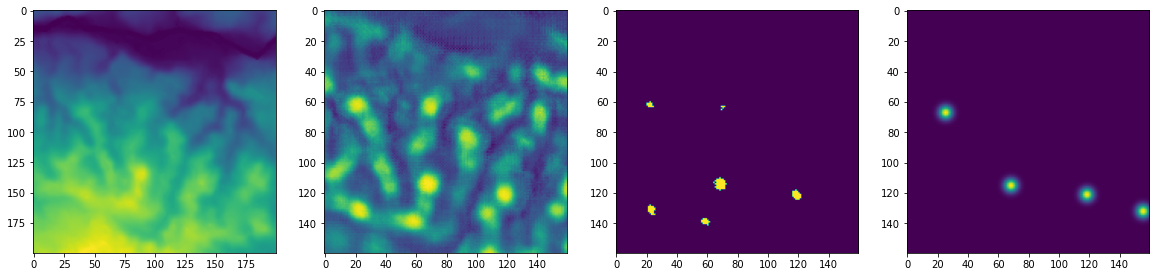

1.0 1.0 1.0
0.0 0.00027186935767531395 0.0


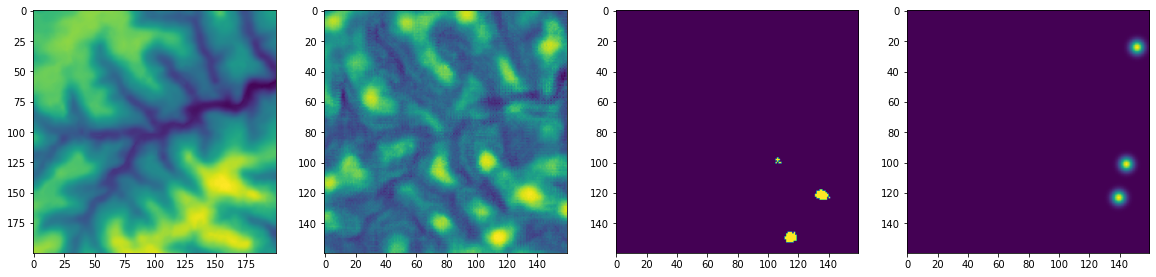


Epoch: 8/20 -- Epoch Time: 2781.02 s
---------------------------------
Train -- Loss: 0.046, Acc: 52.23%
Val -- Loss: 0.046, Acc: 48.56%
1.0 1.0 1.0
0.0 0.0004079823847860098 0.0


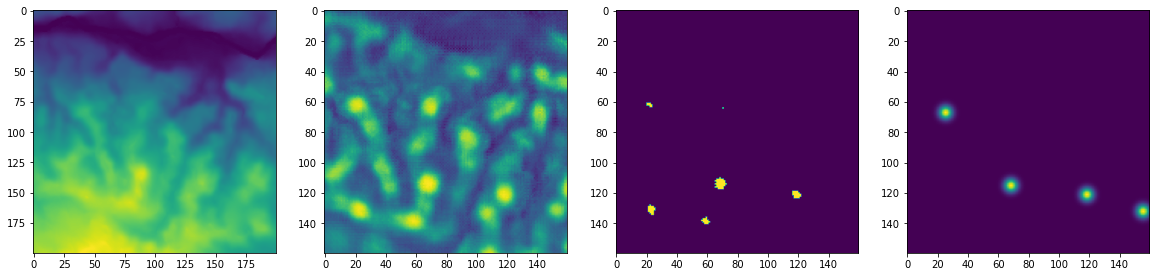

1.0 1.0 1.0
0.0 0.00018534970877226442 0.0


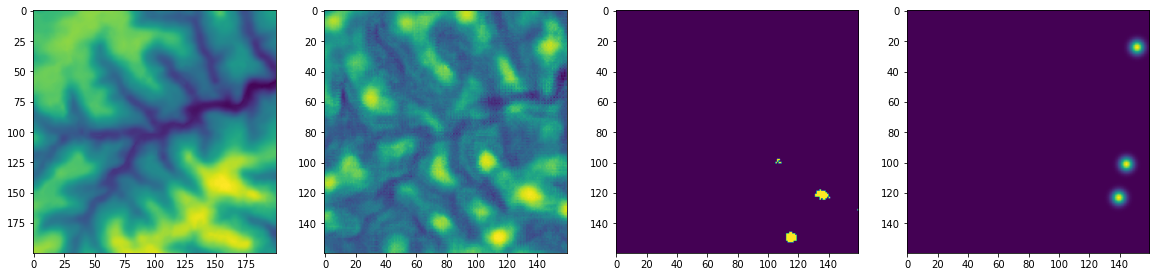


Epoch: 9/20 -- Epoch Time: 2770.63 s
---------------------------------
Train -- Loss: 0.046, Acc: 52.60%
Val -- Loss: 0.046, Acc: 52.90%
1.0 1.0 1.0
0.0 0.0005536308162845671 0.0


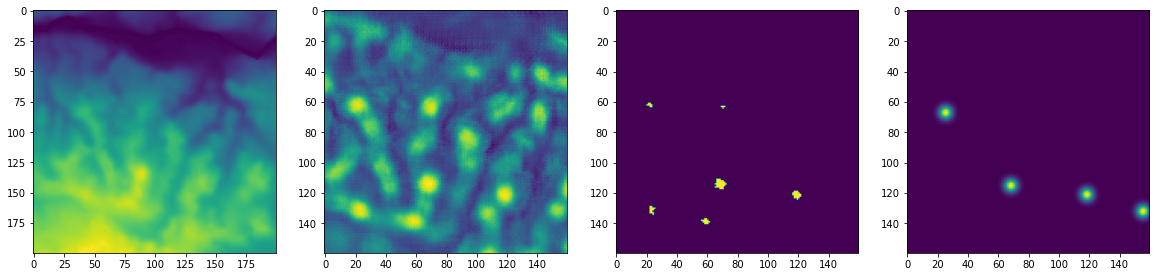

1.0 1.0 1.0
0.0 0.000245040311710909 0.0


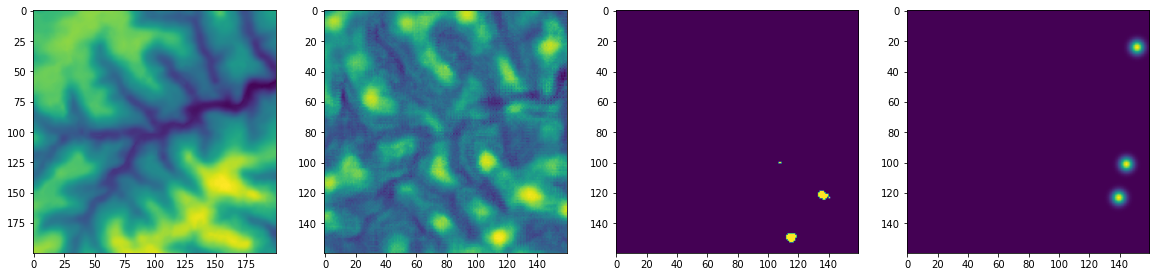


Epoch: 10/20 -- Epoch Time: 2761.45 s
---------------------------------
Train -- Loss: 0.046, Acc: 53.17%
Val -- Loss: 0.046, Acc: 54.32%
1.0 1.0 1.0
0.0 0.0004530827864073217 0.0


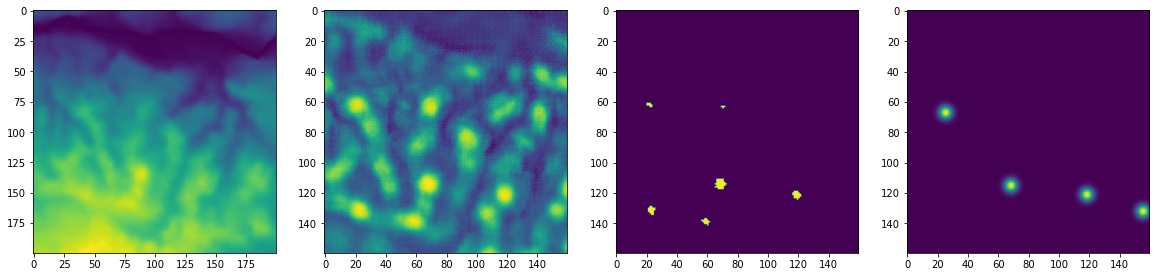

1.0 1.0 1.0
0.0 0.0002097836695611477 0.0


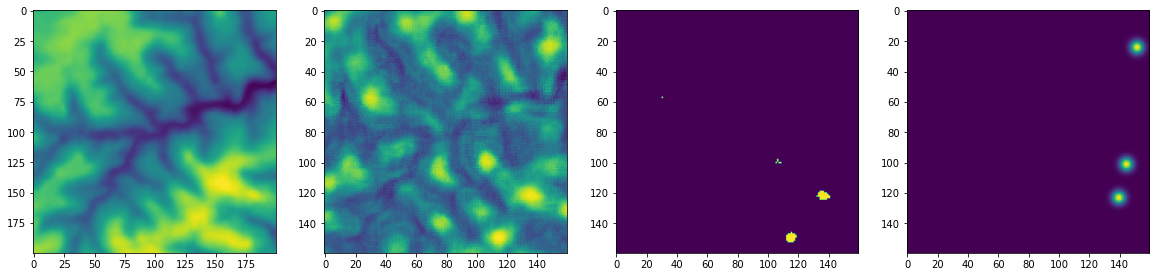


Epoch: 11/20 -- Epoch Time: 2753.16 s
---------------------------------
Train -- Loss: 0.046, Acc: 53.60%
Val -- Loss: 0.046, Acc: 51.55%
1.0 1.0 1.0
0.0 0.0006475920672528446 0.0


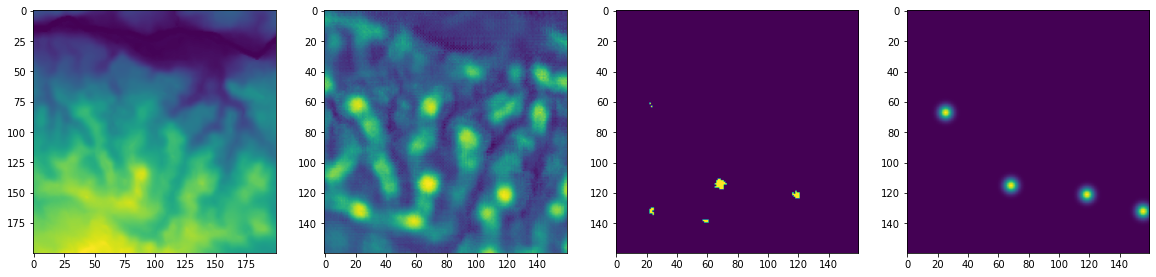

1.0 1.0 1.0
0.0 0.00032961444230750203 0.0


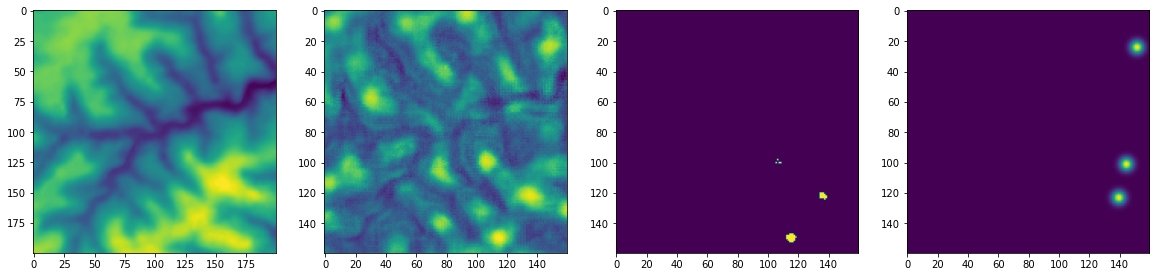


Epoch: 12/20 -- Epoch Time: 2750.09 s
---------------------------------
Train -- Loss: 0.046, Acc: 54.19%
Val -- Loss: 0.046, Acc: 60.81%
1.0 1.0 1.0
0.0 0.0003253361792303622 0.0


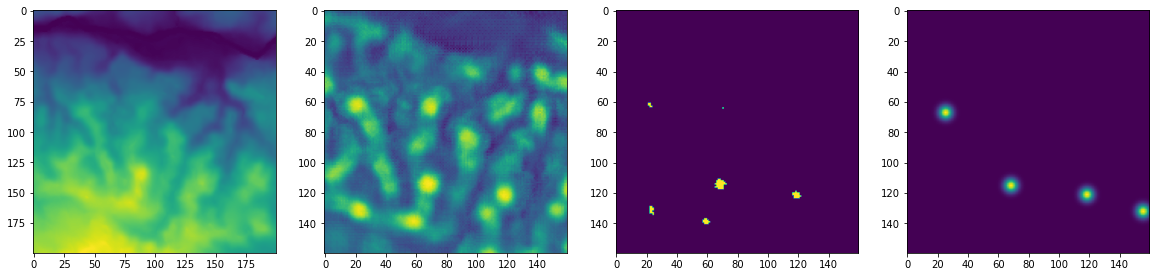

1.0 1.0 1.0
0.0 0.00015455373795703053 0.0


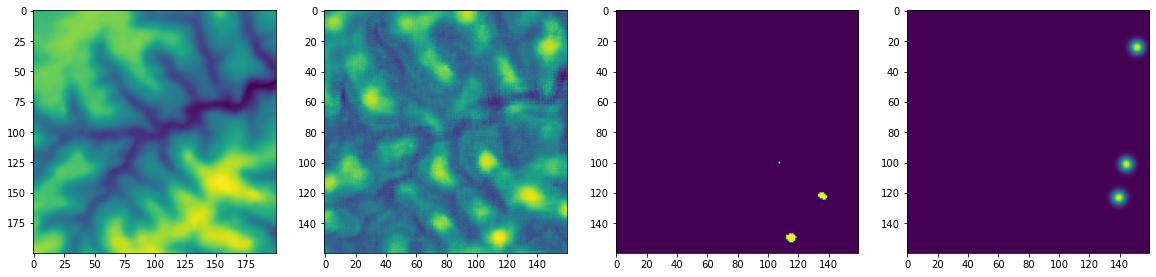


Epoch: 13/20 -- Epoch Time: 2782.11 s
---------------------------------
Train -- Loss: 0.046, Acc: 54.65%
Val -- Loss: 0.046, Acc: 57.48%
1.0 1.0 1.0
0.0 0.0003799870319198817 0.0


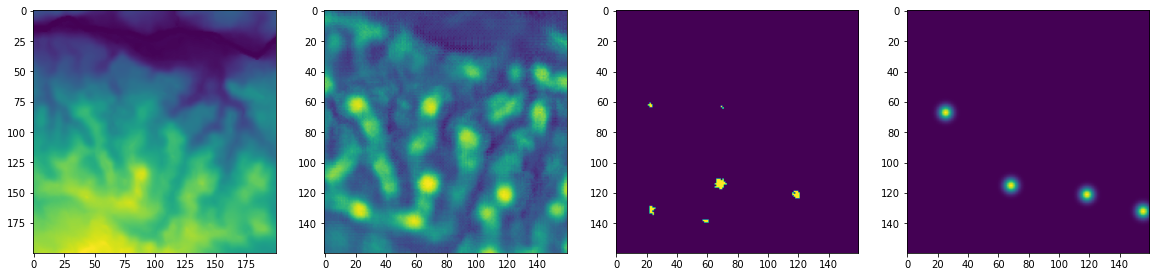

1.0 1.0 1.0
0.0 0.00018163099593948573 0.0


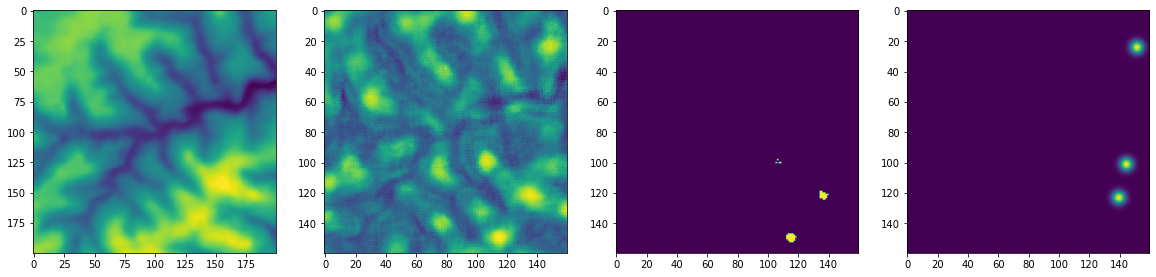


Epoch: 14/20 -- Epoch Time: 2772.86 s
---------------------------------
Train -- Loss: 0.046, Acc: 55.37%
Val -- Loss: 0.046, Acc: 57.51%
1.0 1.0 1.0
0.0 0.00037672504549846053 0.0


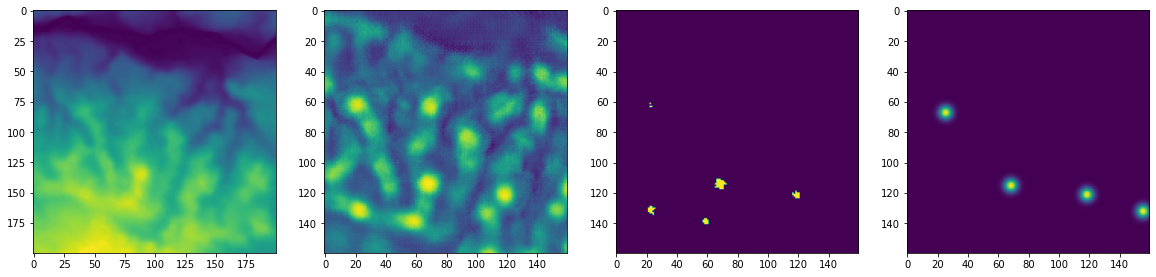

1.0 1.0 1.0
0.0 0.00019241389236412942 0.0


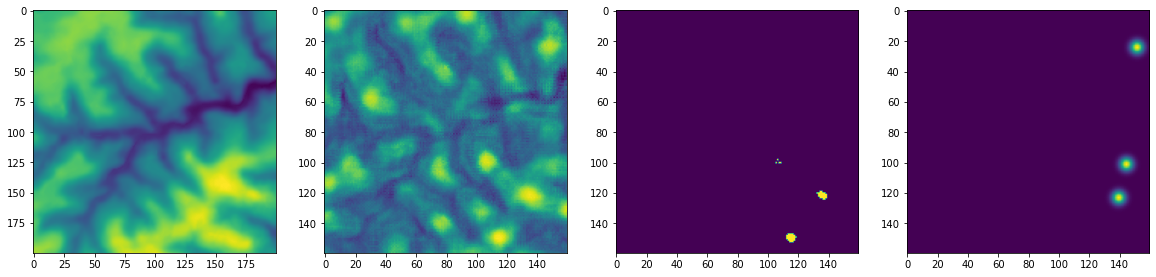


Epoch: 15/20 -- Epoch Time: 2778.35 s
---------------------------------
Train -- Loss: 0.046, Acc: 55.75%
Val -- Loss: 0.046, Acc: 58.40%
1.0 1.0 1.0
0.0 0.00036080219433642924 0.0


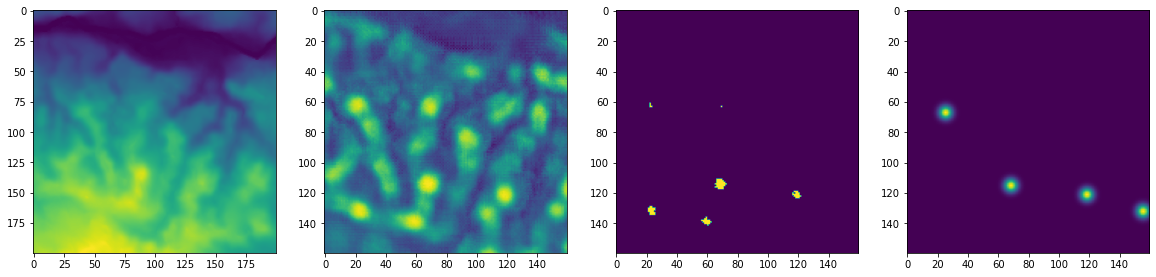

1.0 1.0 1.0
0.0 0.00018787372391670942 0.0


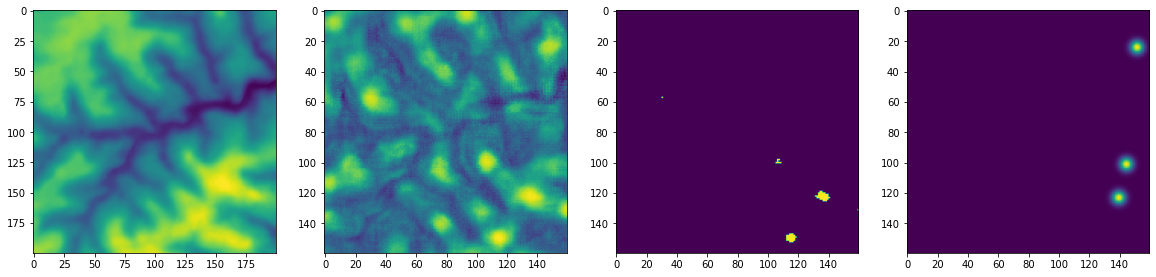


Epoch: 16/20 -- Epoch Time: 2815.41 s
---------------------------------
Train -- Loss: 0.046, Acc: 56.09%
Val -- Loss: 0.046, Acc: 53.10%
1.0 1.0 1.0
0.0 0.00033021060517057776 0.0


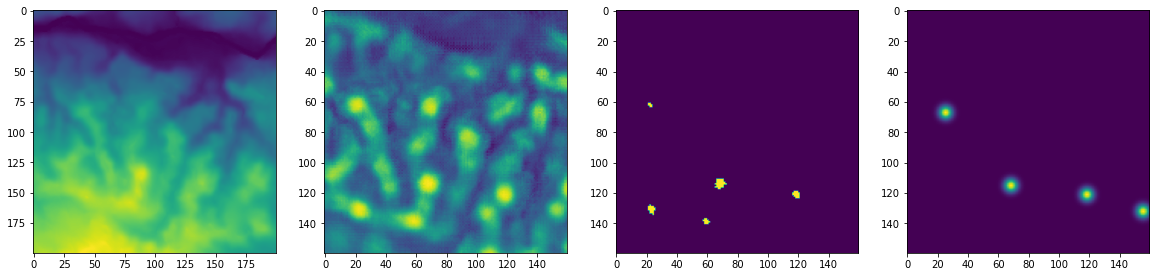

1.0 1.0 1.0
0.0 0.00017245663912035525 0.0


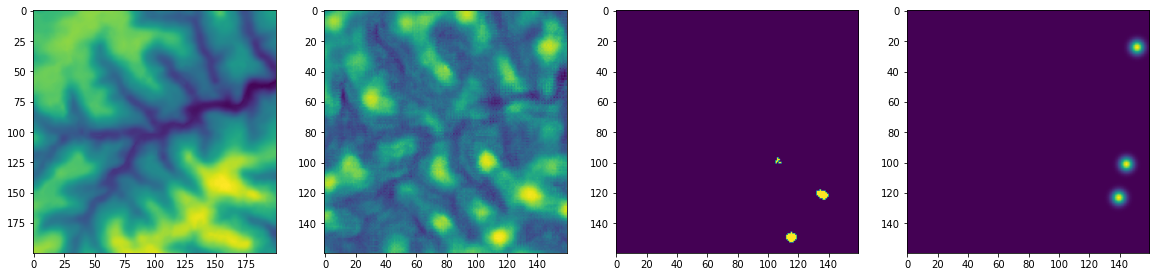


Epoch: 17/20 -- Epoch Time: 3117.07 s
---------------------------------
Train -- Loss: 0.046, Acc: 56.47%
Val -- Loss: 0.046, Acc: 53.52%
1.0 1.0 1.0
0.0 0.0004151613393332809 0.0


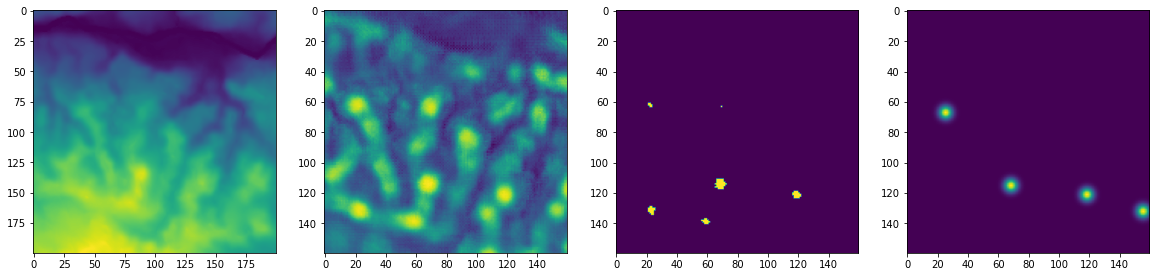

1.0 1.0 1.0
0.0 0.00022326414182316512 0.0


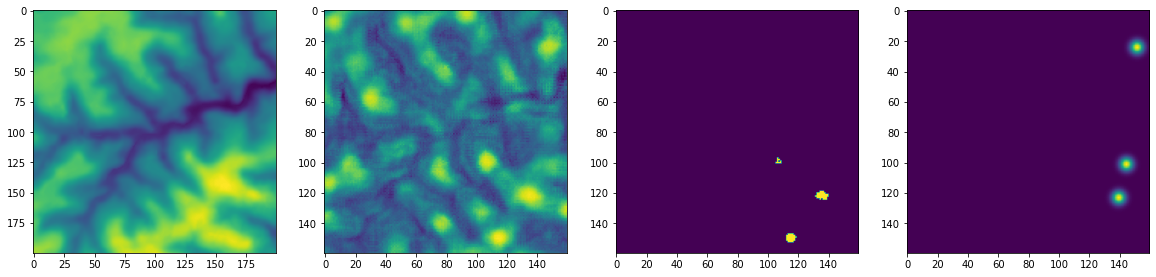


Epoch: 18/20 -- Epoch Time: 3231.85 s
---------------------------------
Train -- Loss: 0.046, Acc: 56.88%
Val -- Loss: 0.046, Acc: 51.38%
1.0 1.0 1.0
0.0 0.00037345910095609725 0.0


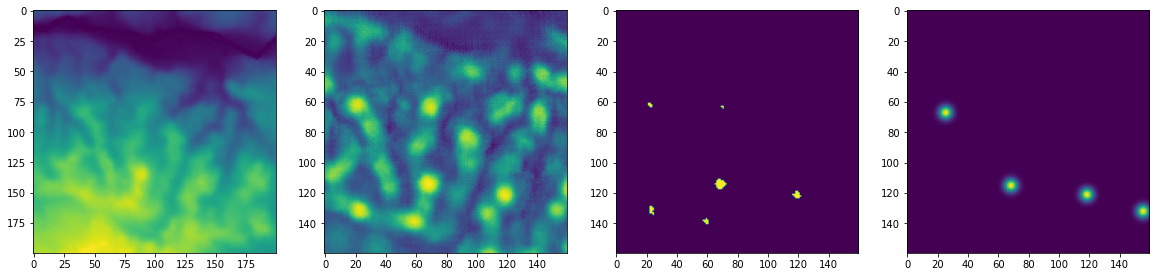

1.0 1.0 1.0
0.0 0.00020994702936150134 0.0


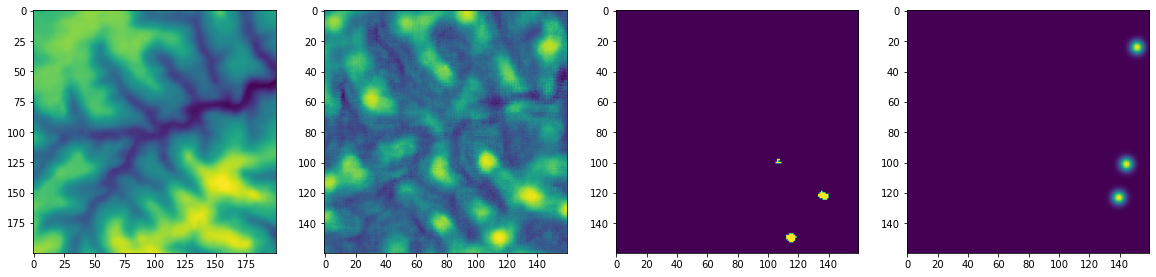


Epoch: 19/20 -- Epoch Time: 3390.63 s
---------------------------------
Train -- Loss: 0.046, Acc: 56.90%
Val -- Loss: 0.045, Acc: 55.87%
1.0 1.0 1.0
0.0 0.00029459554934874177 0.0


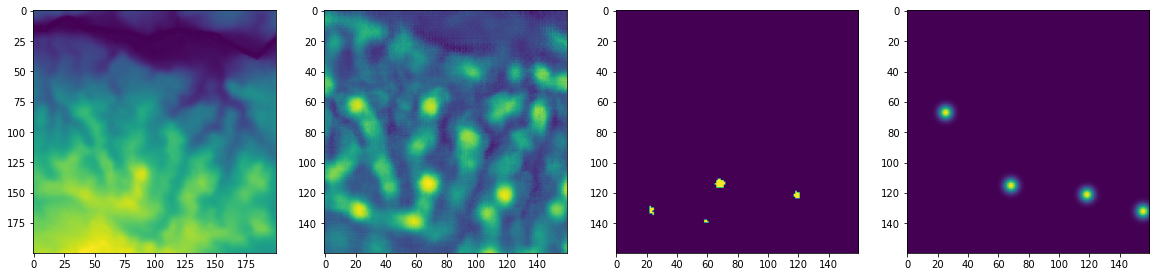

1.0 1.0 1.0
0.0 0.00011918447125935927 0.0


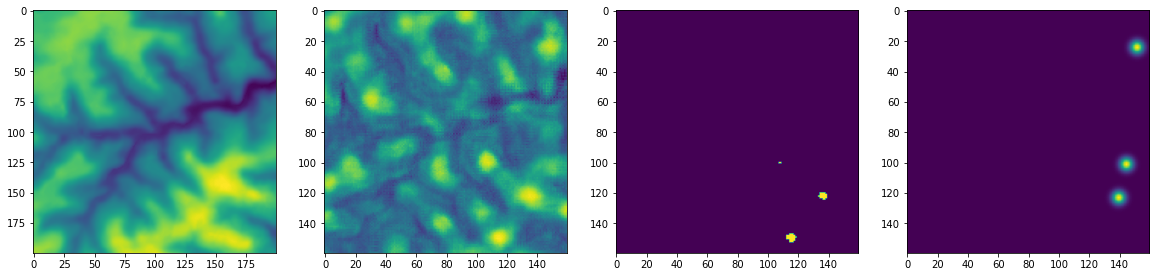


Epoch: 20/20 -- Epoch Time: 3462.21 s
---------------------------------
Train -- Loss: 0.046, Acc: 57.65%
Val -- Loss: 0.045, Acc: 61.00%


In [16]:
N_EPOCHS = 20
#torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'unet_3Peaks_overfit.pt')

In [1]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
  

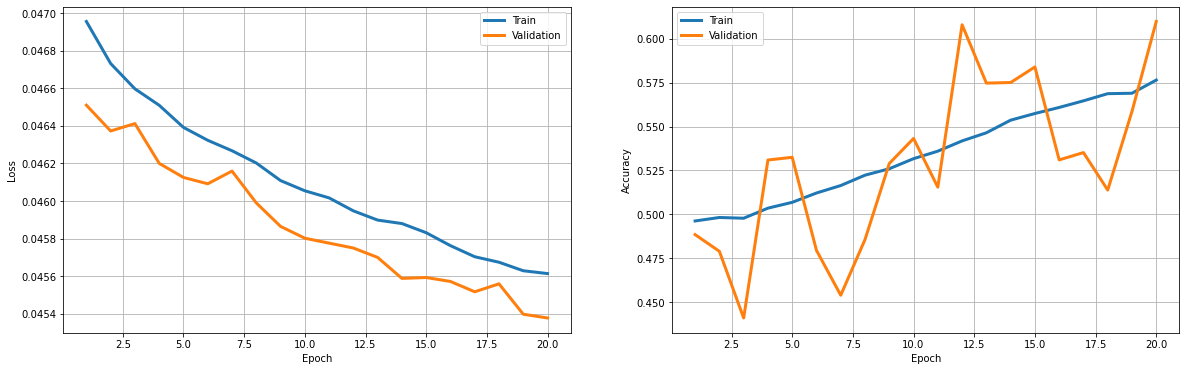

In [18]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [2]:
savePath = "./"
model.save_model(savepath)

NameError: name 'model' is not defined

In [ ]:
# Create iterators
#image_path = "./dataset/"
# Create iterators
#TODO: Maybe change batch Size to 32 if memory runs out
image_path = "./dataset/"
train_data = MountainDataset(image_path)
BATCH_SIZE = 5

iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.cuda.empty_cache()


In [ ]:
criterion = nn.BCEWithLogitsLoss()
# Put model&criterion on GPU



loadPath = "./unet_3Peaks.pt"
model = torch.load(loadPath)
#optimizer = optim.SGD(model.parameters(), lr = startLR)

model.eval()


#torch.cuda.empty_cache()

criterion = criterion.to(device)
model = model.to(device)

print(evaluate(model, iterator, criterion, device))


In [ ]:
criterion = nn.BCEWithLogitsLoss()
# Put model&criterion on GPU

loadPath = "onepeak.pt"
model = torch.load(loadPath)
#optimizer = optim.SGD(model.parameters(), lr = startLR)

model.eval()



torch.cuda.empty_cache()

criterion = criterion.to(device)
model = model.to(device)




print(evaluate(model, iterator, criterion, device))